In [5]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint
from tqdm import tqdm

Lorentz equations:

In [6]:
#  From https://scipython.com/blog/the-lorenz-attractor/
# Lorenz parameters and initial conditions.
sigma, beta, rho = 10, 2.667, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE

class Lambda(nn.Module):
    def forward(self, t, y):
        """The Lorenz equations."""
        u, v, w = y[0]
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return torch.tensor([[up, vp, wp]]).to(device)

Obtain true values from numerical DE solver:

In [7]:
t = torch.linspace(0., 25., 1000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values
true_y

tensor([[[ 0.0000,  1.0000,  1.0500]],

        [[ 0.2247,  1.0529,  0.9851]],

        [[ 0.4278,  1.2454,  0.9306]],

        ...,

        [[ 9.4671, 14.7670, 19.7274]],

        [[10.8097, 16.1635, 22.2666]],

        [[12.0994, 16.9408, 25.4477]]])

Define Neural ODE:

In [8]:
class ODENN(nn.Module):

    def __init__(self):
        super(ODENN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
        )

        for m in self.layers.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.layers(y)
    

        

train loop:

In [9]:
def train(net, true_y, t, optimizer, epochs, train_ratio=1):
        validation = False if train_ratio == 1 else True
        train_y = true_y[:int(len(true_y)*train_ratio)]
        train_t = t[:int(len(t)*train_ratio)]
        validation_y = true_y[int(len(true_y)*train_ratio):]
        validation_t = t[int(len(t)*train_ratio):]
        train_losses, validation_losses, iterations = [],[],[]
        for epoch in tqdm(range(epochs)):
            pred_y = odeint(net, train_y[0], train_t).to(device)
            loss = torch.mean(torch.abs(pred_y - train_y))
            loss.backward()
            optimizer.step()
            iterations.append(epoch)
            train_losses.append(float(loss))
            if validation:
                with torch.no_grad():
                    pred_y = odeint(net, validation_y[0], validation_t)
                loss = torch.mean(torch.abs(pred_y - validation_y))
                validation_losses.append(float(loss))

        plt.plot(iterations, train_losses, label='training loss')
        if validation:
            plt.plot(iterations, validation_losses, label='validation loss')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        print(f"Final training loss: {train_losses[-1]}")
    

100%|██████████| 200/200 [01:50<00:00,  1.80it/s]


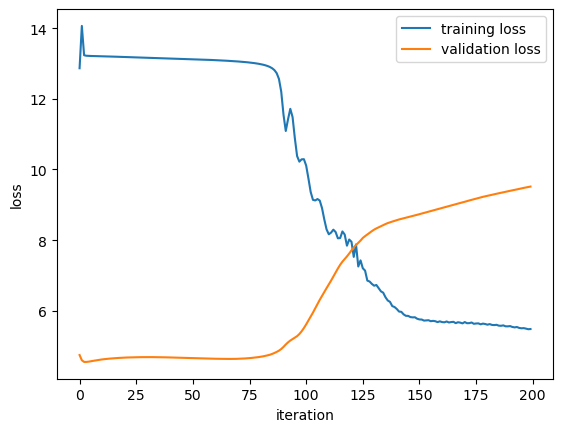

Final training loss: 5.483217716217041


In [10]:
net=ODENN().to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)
train(net, true_y, t, optimizer, epochs=200, train_ratio=0.9)

Plotting:

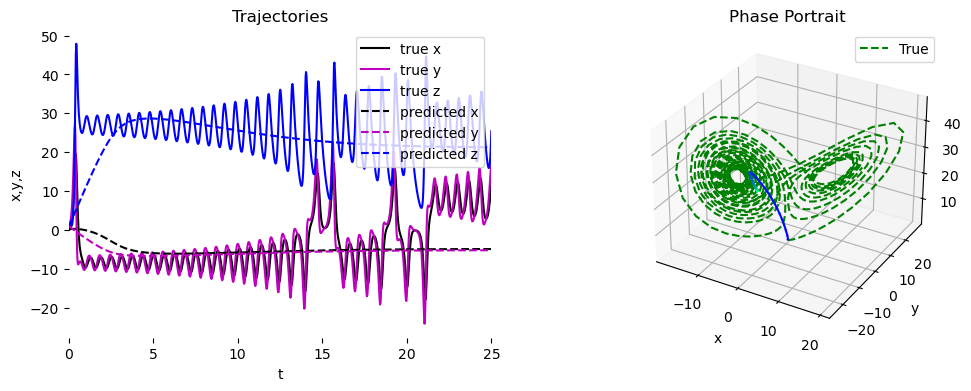

In [14]:
with torch.no_grad():
    pred_y = odeint(net, true_y[0], t)

fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(121, frameon=False)
ax_phase = fig.add_subplot(122, projection='3d')

ax_traj.cla()
ax_traj.set_title('Trajectories')
ax_traj.set_xlabel('t')
ax_traj.set_ylabel('x,y,z')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,0], 'k-', label='true x')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,1], 'm-', label='true y')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,2], 'b-', label='true z')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,0], 'k--', label='predicted x')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,1], 'm--', label='predicted y')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,2], 'b--', label='predicted z')
ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
#ax_traj.set_ylim(-2, 2)
ax_traj.legend()

ax_phase.cla()
ax_phase.set_title('Phase Portrait')
ax_phase.plot(true_y.cpu().numpy()[:,:,0], true_y.cpu().numpy()[:,:,1], true_y.cpu().numpy()[:,:,2], 'g--', label="True")

s=10
n=len(t)
line_segments = [(pred_y.cpu().numpy()[:,:,0][i:i+s+1], pred_y.cpu().numpy()[:,:,1][i:i+s+1], pred_y.cpu().numpy()[:,:,2][i:i+s+1]) for i in range(0,n-s,s)]
segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
#lines = Line3DCollection(line_segments, colors = segment_colours, label='Predicted')
#ax_phase.add_collection(lines)
for i, line in enumerate(line_segments):
    ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

#ax_phase.plot(pred_x, pred_y, pred_z, 'b--')
ax_phase.set_xlabel('x')
ax_phase.set_ylabel('y')
ax_phase.set_zlabel('z')
ax_phase.legend()
plt.show()